## Import Dataset

In [8]:
import pandas as pd
import missingno as msno

In [4]:
df = pd.read_csv("breast_cancer.csv")
pd.set_option('display.max_columns', None)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [7]:
df['target'].value_counts() # cek imbalance

,count
target,
1.0,357
0.0,212


<Axes: >

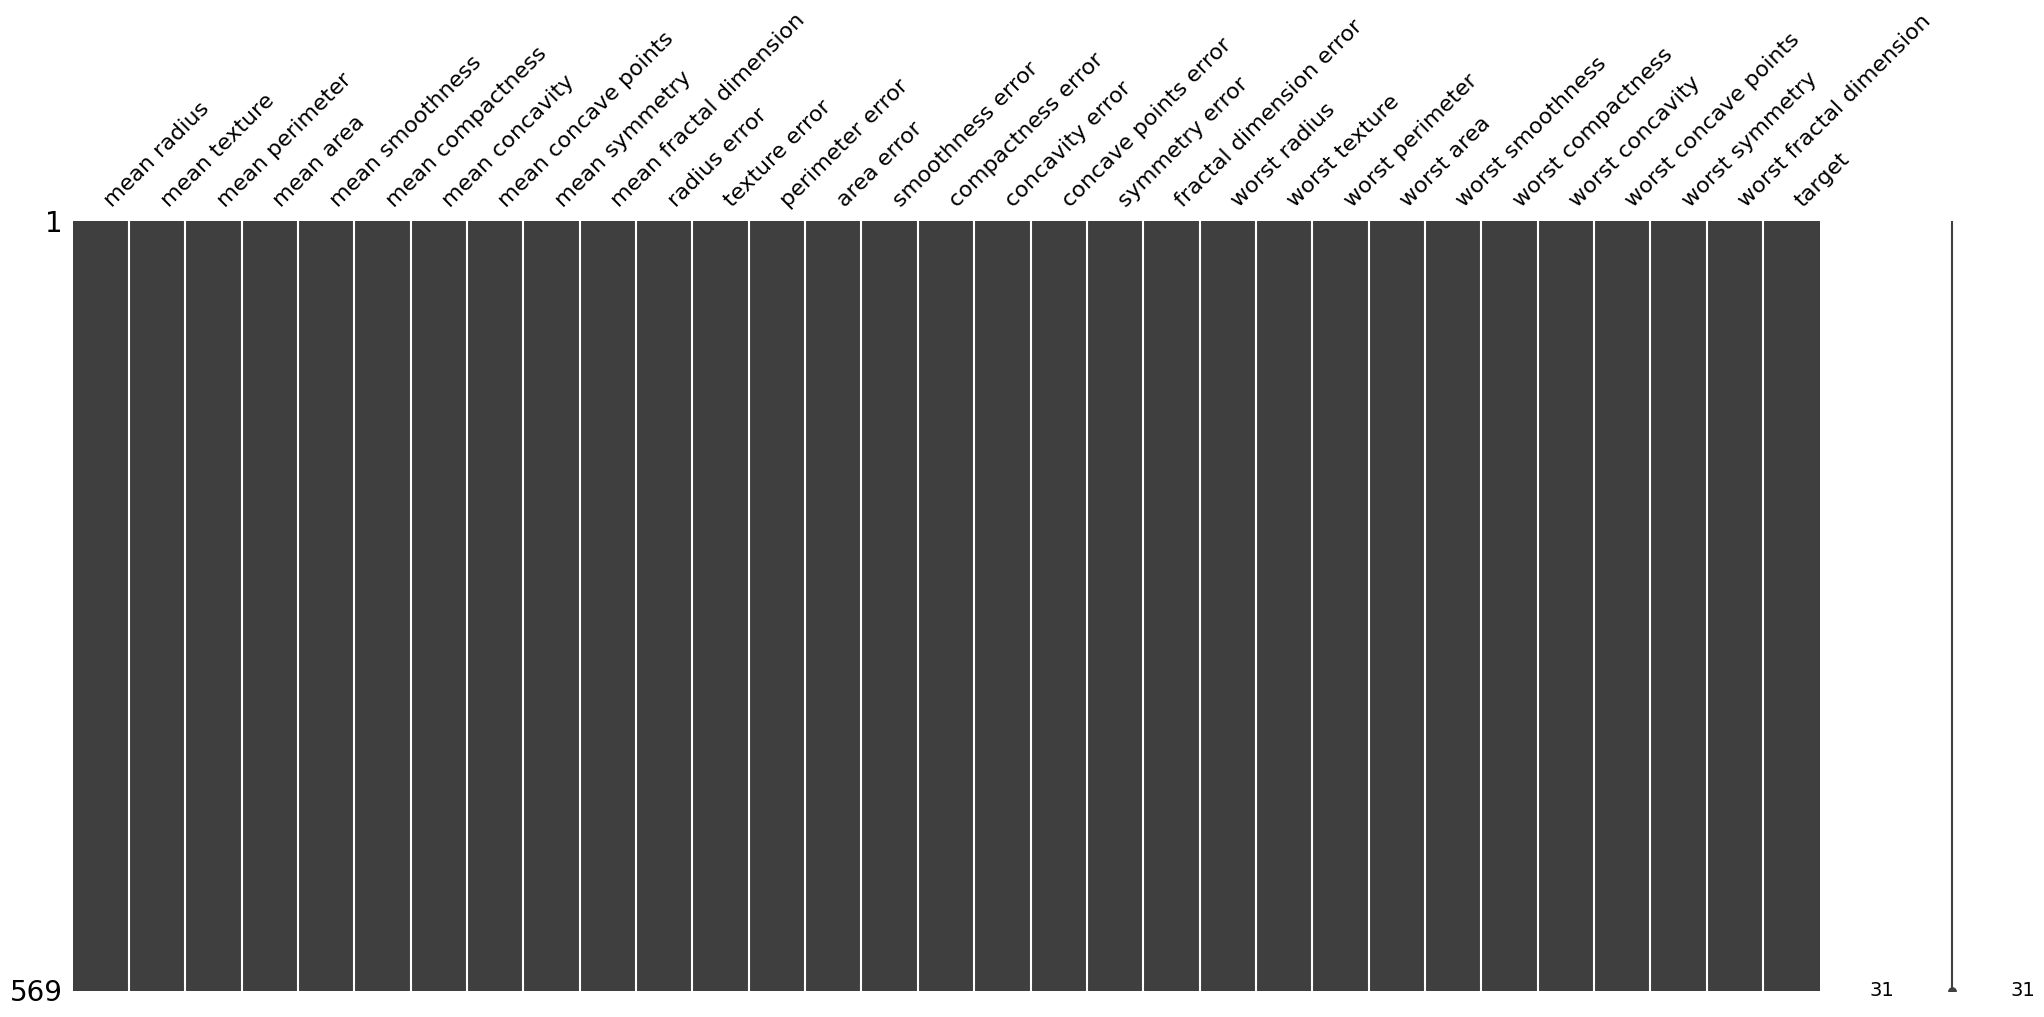

In [9]:
msno.matrix(df) # cek missing values

## Splitting

In [11]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="target")
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

## Comulative Explained Variance

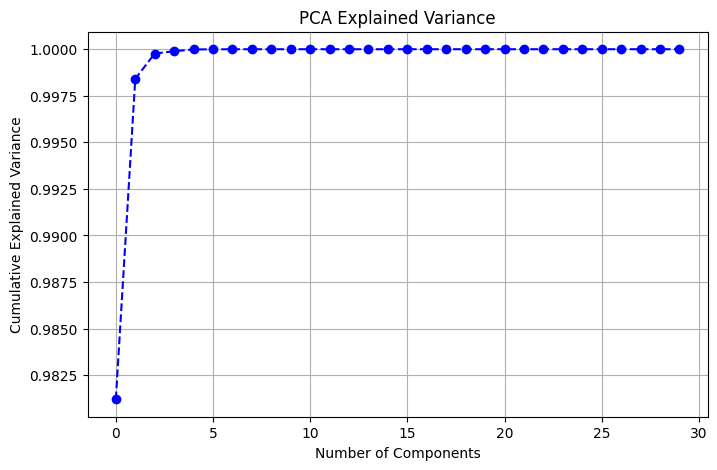

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(X_train)

plt.figure(figsize=(8, 5))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

In [13]:
n_components = (pca.explained_variance_ratio_.cumsum() >= 0.95).argmax() + 1
print(f"Jumlah komponen optimal untuk 95% varians: {n_components}")

Jumlah komponen optimal untuk 95% varians: 1


## Training

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform , randint

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
        ]), X_train.columns),
    ]
)

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca', PCA(whiten=True)),
    ('algo', SVC(max_iter=500))
])

parameter = {
    'pca__n_components': randint(5, min(X_train.shape[1], 50)),
    'algo__C': loguniform(0.01, 100),
    'algo__degree': [2, 3, 4],
    'algo__gamma': loguniform(1e-4, 10),
    'algo__coef0': loguniform(0.01, 2),
}

In [76]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomizedSearchCV(pipeline, param_distributions=parameter, cv=5, scoring='accuracy', n_iter=10, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'algo__C': 17.12337597316399, 'algo__coef0': 0.05022563311994769, 'algo__degree': 2, 'algo__gamma': 0.0014271483774997201, 'pca__n_components': 19}
0.9692307692307692 0.9604395604395604 0.9736842105263158


## Evaluasi Model

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test, average='weighted')
recall_test = recall_score(y_test, y_pred_test, average='weighted')
f1_test = f1_score(y_test, y_pred_test, average='weighted')

accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')

print(f"Jumlah data train: {X_train.shape[0]}")
print(f"Jumlah data test: {X_test.shape[0]}\n")

print("**Evaluasi pada Data Train**")
print(f"Akurasi: {accuracy_train:.4f}")
print(f"Precision: {precision_train:.4f}")
print(f"Recall: {recall_train:.4f}")
print(f"F1-Score: {f1_train:.4f}\n")

print("**Evaluasi pada Data Test**")
print(f"Akurasi: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")

Jumlah data train: 455
Jumlah data test: 114

**Evaluasi pada Data Train**
Akurasi: 0.9692
Precision: 0.9702
Recall: 0.9692
F1-Score: 0.9690

**Evaluasi pada Data Test**
Akurasi: 0.9737
Precision: 0.9747
Recall: 0.9737
F1-Score: 0.9735


In [78]:
from sklearn.metrics import classification_report

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Classification Report - Train Data:")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report - Test Data:")
print(classification_report(y_test, y_test_pred))

Classification Report - Train Data:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.96       170
         1.0       0.96      1.00      0.98       285

    accuracy                           0.97       455
   macro avg       0.97      0.96      0.97       455
weighted avg       0.97      0.97      0.97       455


Classification Report - Test Data:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        42
         1.0       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



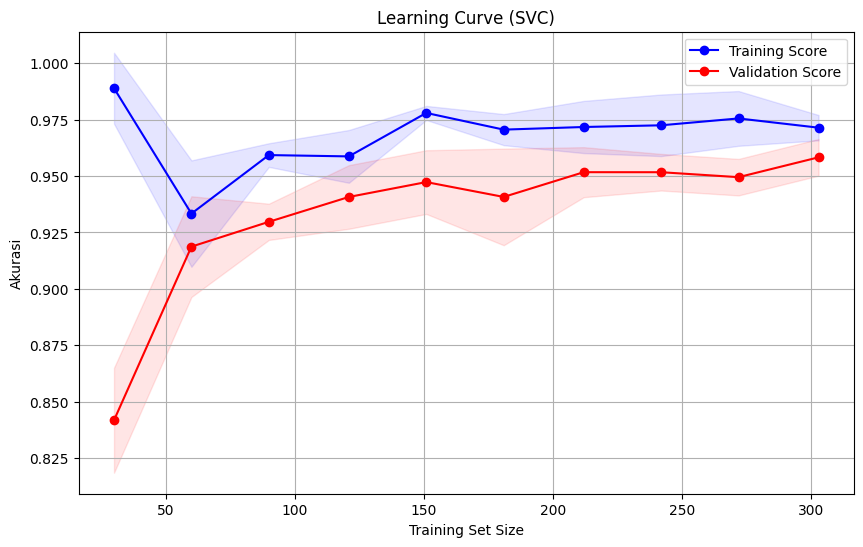

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

best_model = model.best_estimator_

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=3, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="red", label="Validation Score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="red")

plt.xlabel("Training Set Size")
plt.ylabel("Akurasi")
plt.title("Learning Curve (SVC)")
plt.legend()
plt.grid()
plt.show()

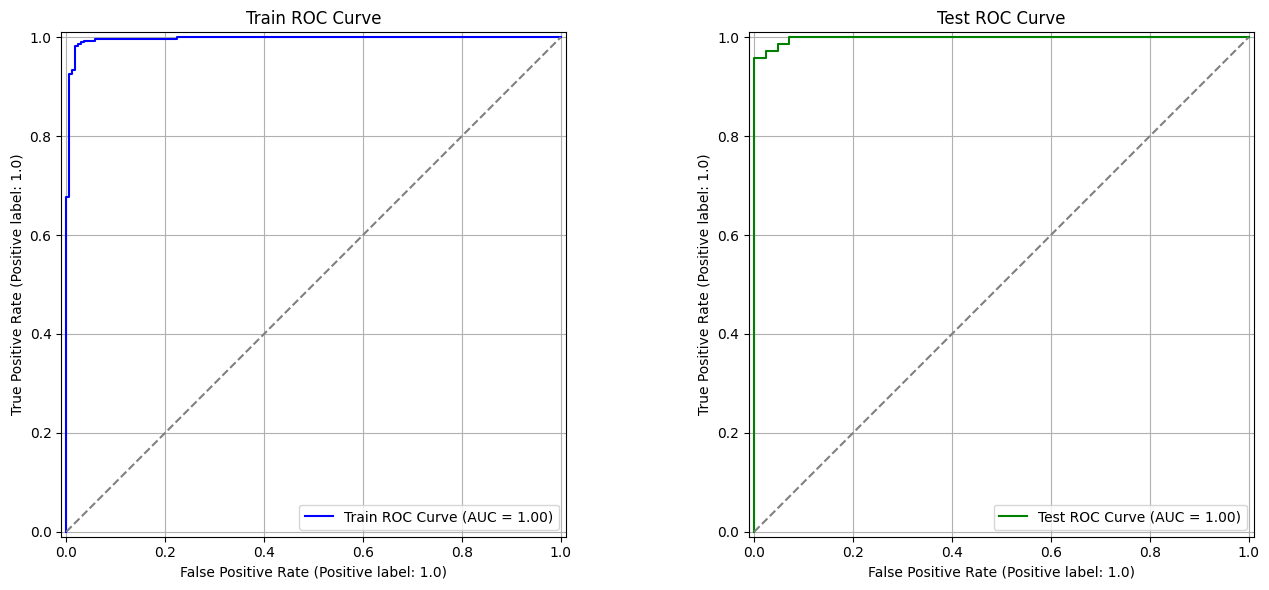

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

RocCurveDisplay.from_estimator(
    model, X_train, y_train, ax=axes[0], name="Train ROC Curve", color="blue"
)
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_title("Train ROC Curve")
axes[0].grid()

RocCurveDisplay.from_estimator(
    model, X_test, y_test, ax=axes[1], name="Test ROC Curve", color="green"
)
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("Test ROC Curve")
axes[1].grid()

plt.tight_layout()
plt.show()

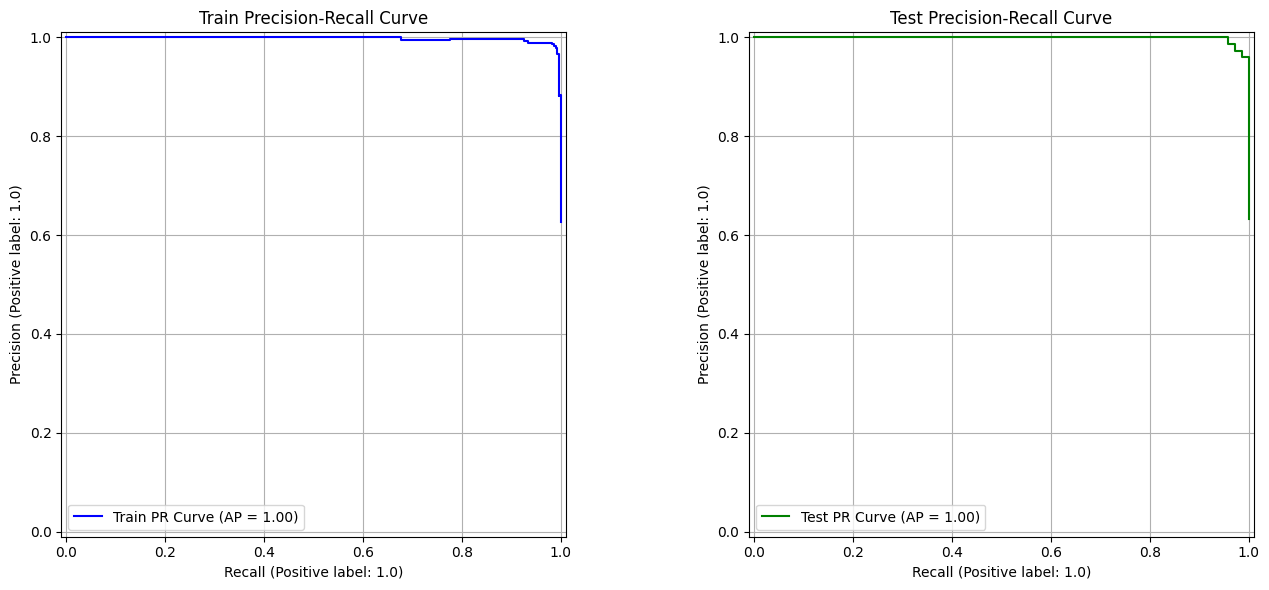

In [83]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    model, X_train, y_train, ax=axes[0], name="Train PR Curve", color="blue"
)
axes[0].set_title("Train Precision-Recall Curve")
axes[0].grid()

PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, ax=axes[1], name="Test PR Curve", color="green"
)
axes[1].set_title("Test Precision-Recall Curve")
axes[1].grid()

plt.tight_layout()
plt.show()

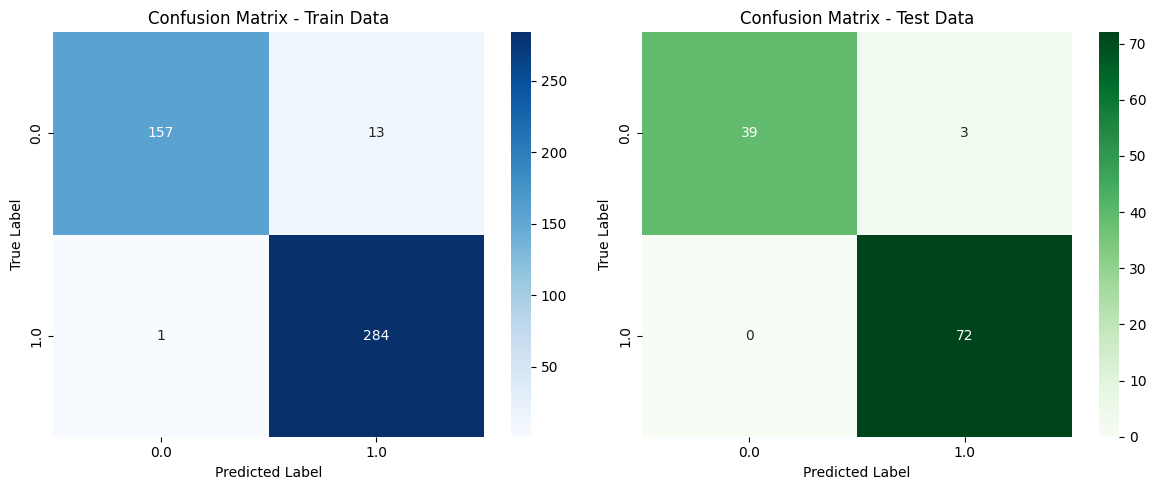

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix - Train Data")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Data")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

## Save Model

In [87]:
import pickle

best_pipeline = model.best_estimator_
with open("breast_cancer.pkl", "wb") as file:
    pickle.dump(best_pipeline, file)